In [50]:
import requests
import pandas as pd
import urllib.request
import re
import time
from tqdm import tqdm

In [51]:
# from tensorflow.keras.applications import vgg16
# from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image

import numpy as np
import pandas as pd
import os
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [52]:
ikea_data = pd.read_csv('data/ikea_products.csv', index_col=False)
hipvan_data = pd.read_csv('data/hipvan_products.csv', index_col=False)

ikea_category = list(ikea_data.category_name.unique())
hipvan_category = list(hipvan_data.category.unique())
all_category = ikea_category + hipvan_category

# Prepare the training folder and image file list
image_folder_name = ['ikea_image', 'hipvan_image']
image_file_path = []

for folder_name in image_folder_name:
    for subfolder in all_category:
        try:
            file_list = os.listdir(folder_name + '/' + subfolder)
            for file in file_list:
                image_file_path.append(folder_name + '/' + subfolder + '/' + file)
        except:
            pass

image_file_path_df = pd.DataFrame({'image_file_path': image_file_path})
image_file_path_df['label'] = image_file_path_df.image_file_path.str.split(pat = '/').str[1]

# train_image_file_list, test_image_file_list, train_label, test_label = train_test_split(image_file_path_df.image_file_path, image_file_path_df.label, test_size=0.2, random_state=42, stratify = image_file_path_df.label)

train_image_file_list = image_file_path_df.image_file_path
train_label = image_file_path_df.label


train_image_file_list = train_image_file_list.to_list()
# test_image_file_list = test_image_file_list.to_list()



In [57]:
# pd.DataFrame(train_image_file_list).to_csv('data/file_list.csv', index=0)

In [61]:
train_image_file_list = pd.read_csv('data/file_list.csv',).iloc[:, 0].to_list()

In [62]:
len(train_image_file_list)

23271

In [63]:
# vgg_model = vgg16.VGG16(weights='imagenet', include_top=True)
# # vgg_model.summary()

# # Define VGG extracting block5_conv3 layer coefficients
# vgg_model_extract_blk5conv3 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv3').output)

efficientnetb7_model = EfficientNetB7(weights='imagenet', include_top=True)
efficientnetb7_model = Model(inputs=efficientnetb7_model.input, outputs=efficientnetb7_model.get_layer('avg_pool').output)

# display function to show image
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

#//////

def extract_efficientnetb7_model_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in tqdm(enumerate(image_file_list)):
#         if ((idx % 100) ==0 ):
#             print("process %d/%d file" % (idx+1, len(image_file_list)))
    
        img = image.load_img(eachFile, target_size=(600, 600))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        conv_features = efficientnetb7_model.predict(x)
        if (mode == 'sum'):
#             conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features)
    return all_feature

def extract_efficientnetb7_model_from_image(image):
    all_feature = []
    
    x = cv2.resize(image, (600,600), interpolation = cv2.INTER_AREA)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    conv_features = efficientnetb7_model.predict(x)
    conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
    all_feature.append(conv_features)
    
    return all_feature

#///////
    
def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 100) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
            
        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        conv_features = vgg_model_extract_blk5conv3.predict(x)
        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features)
    return all_feature

def extract_vgg_conv_feature_from_image(image):
    all_feature = []
    x = Image.fromarray(image).resize(size=(224,224))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    conv_features = vgg_model_extract_blk5conv3.predict(x)

    conv_features = np.sum(conv_features, axis=(1,2))
    conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
    all_feature.append(conv_features)
    
    return all_feature

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)

In [ ]:
# # # Uncomment followings to re-calculate all features
# # Extract features from training images
# train_all_feature_efficientnetb7_model = extract_efficientnetb7_model_from_list(train_image_file_list)
# np.save('data/train_all_feature_efficientnetb7_model.npy', train_all_feature_efficientnetb7_model)
# print("Feature list length: (%d)" % (train_all_feature_efficientnetb7_model.shape[0]))



In [ ]:
print(train_all_feature_efficientnetb7_model)
print(train_image_file_list)

In [66]:
# Use the pre-calculated features provided in the workshop

train_all_feature_efficientnetb7_model = np.load('data/train_all_feature_efficientnetb7_model.npy')
print("Feature list length: (%d)" % (train_all_feature_efficientnetb7_model.shape[0]))



Feature list length: (23271)


In [29]:
def search_image(image, return_top = 5):
    test_img_feature = extract_efficientnetb7_model_from_image(image)

    top_return = 5
    dist_list = []
    final_filename = []
    final_path = []
    for eachpic in range(len(train_all_feature_efficientnetb7_model)):
        dist = cal_vec_dist(test_img_feature, train_all_feature_efficientnetb7_model[eachpic])
        dist_list.append(dist)
        final_path.append(train_image_file_list[eachpic])
        final_filename.append(train_image_file_list[eachpic].split('/')[2])
    result = pd.DataFrame({'dist': dist_list, 'filename': final_filename, 'path': final_path})
    result = result.sort_values(by='dist').drop_duplicates('filename')
    return result[:return_top].path.tolist()


In [38]:
len(train_all_feature_efficientnetb7_model)

23271

In [67]:
len(train_image_file_list)

23271

In [68]:
def search_image_path(image, return_top = 5):
    test_img_feature = extract_efficientnetb7_model_from_list(image)#[0]

    top_return = 5
    dist_list = []
    final_filename = []
    final_path = []
    for eachpic in range(len(train_all_feature_vgg_conv)):
        dist = cal_vec_dist(test_img_feature, train_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)
        final_path.append(train_image_file_list[eachpic])
        final_filename.append(train_image_file_list[eachpic].split('/')[2])
    result = pd.DataFrame({'dist': dist_list, 'filename': final_filename, 'path': final_path})
    result = result.sort_values(by='dist').drop_duplicates('filename')
    return result[:return_top].path.tolist()


In [83]:
train_image_file_list[200:300]

['ikea_image/Smart lighting/TRÅDFRI_LED bulb E27 806 lumen_70410065.jpg',
 'ikea_image/Smart lighting/FLOALT_LED light panel_40436316.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Wireless motion sensor_90370469.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Shortcut button_80356384.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Dimmer kit_50435929.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Remote control_00443125.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Remote control kit_10406556.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Control outlet kit_10364797.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Gateway_40337806.jpg',
 'ikea_image/Smart lighting/LINDSHULT_LED cabinet lighting_10260436.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_Gateway kit_80406911.jpg',
 'ikea_image/Smart lighting/STRÖMLINJE_LED worktop lighting_00343041.jpg',
 'ikea_image/Smart lighting/FLOALT_LED light panel_20436317.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_LED bulb E14 600 lumen_90411568.jpg',
 'ikea_image/Smart lighting/T

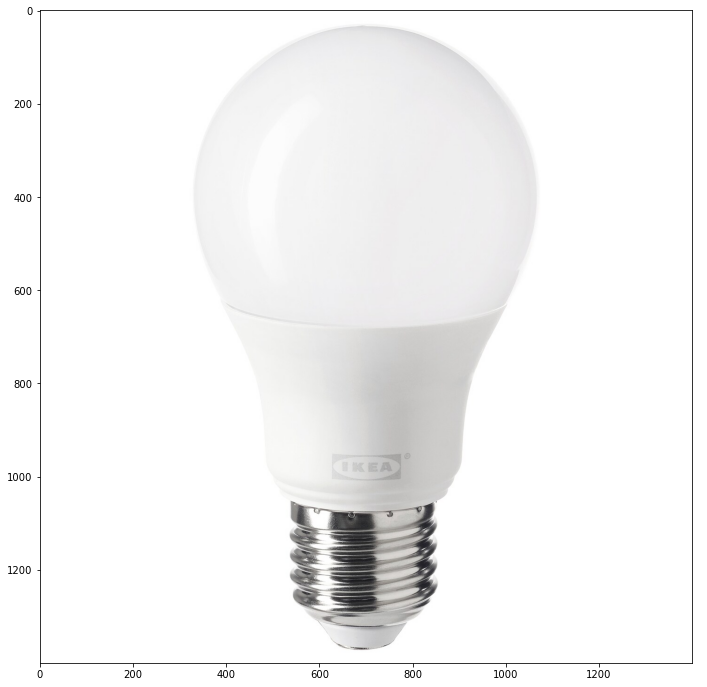

In [84]:
test_img = cv2.cvtColor(cv2.imread('ikea_image/Smart lighting/TRÅDFRI_LED bulb E27 806 lumen_70410065.jpg'), cv2.COLOR_BGR2RGB)
display_img(test_img)

In [85]:
search_image(test_img)

['ikea_image/Smart lighting/TRÅDFRI_LED bulb E27 806 lumen_70410065.jpg',
 'ikea_image/LED light bulbs/LEDARE_LED bulb E27 1055 lumen_80438686.jpg',
 'ikea_image/LED light bulbs/LEDARE_LED bulb E27 806 lumen_30438599.jpg',
 'ikea_image/Smart lighting/TRÅDFRI_LED bulb E14 600 lumen_00408594.jpg',
 'ikea_image/LED light bulbs/RYET_LED bulb E27 470 lumen_00438708.jpg']

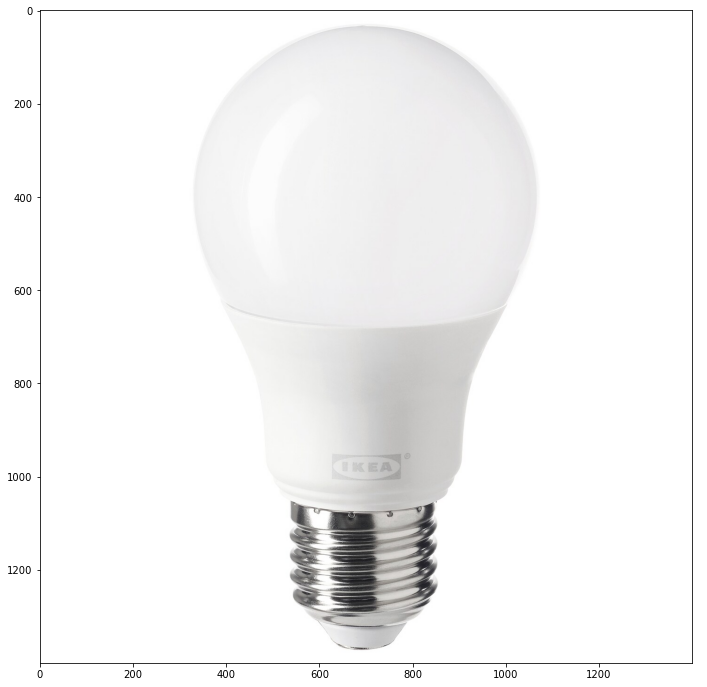

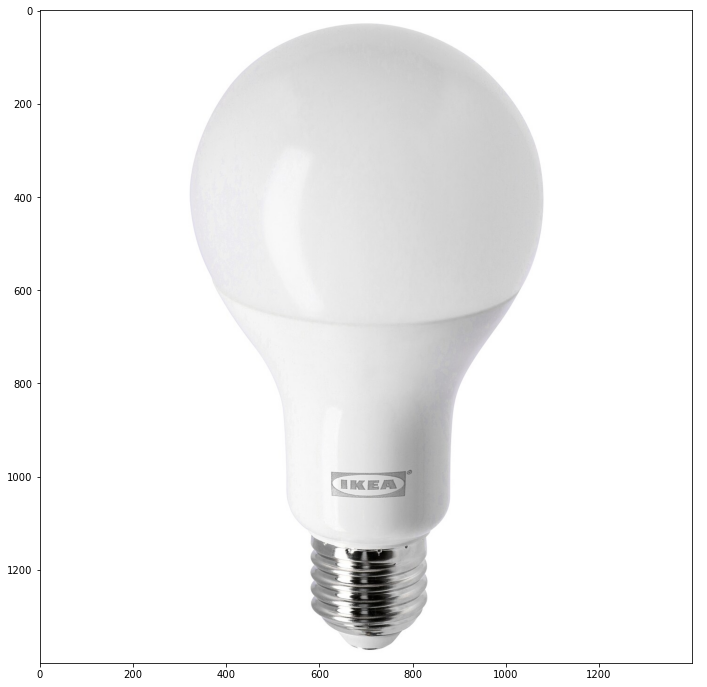

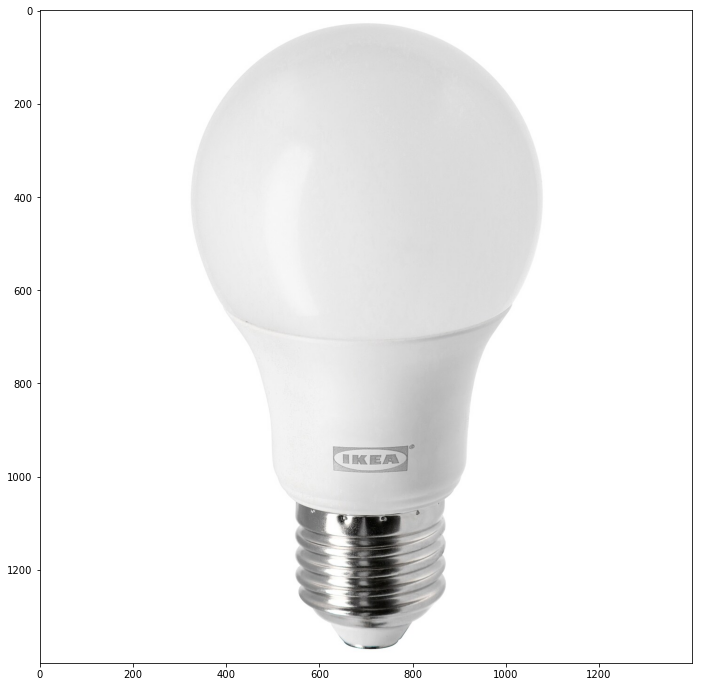

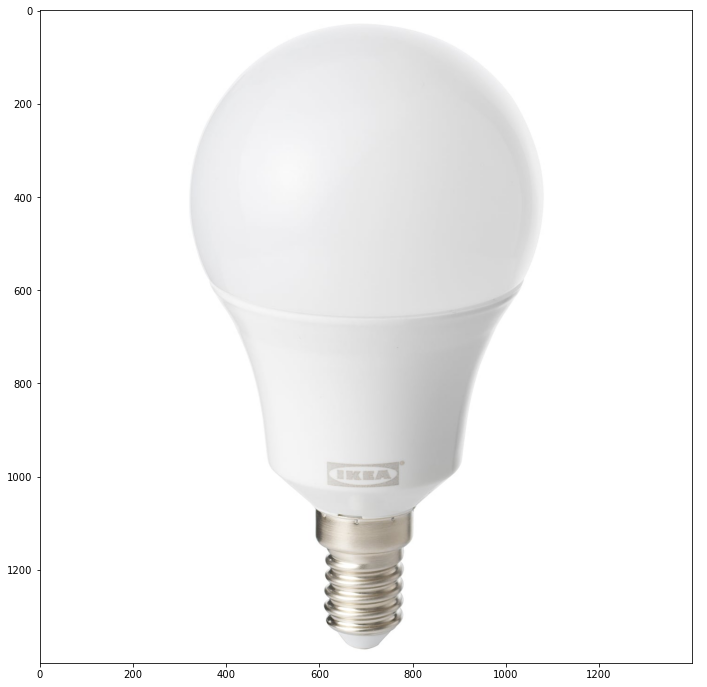

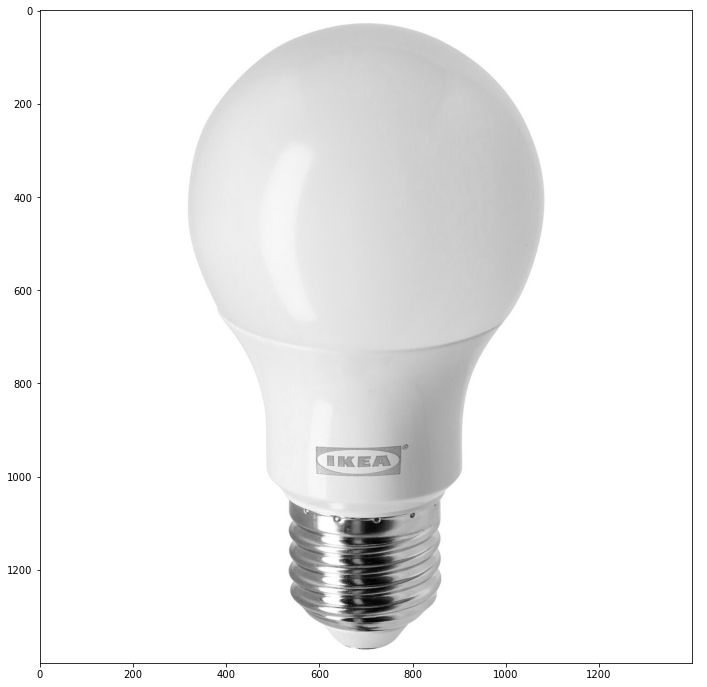

In [86]:
for _ in search_image(test_img):
    display_img(cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2RGB))